In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from adjustText import adjust_text
from collections import Counter
from matplotlib import pyplot as plt
from util import calc_proteome_nosc

In [2]:
# Load amino acid NOSC table
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv').set_index('letter_code')
aa_nosc_df.head()

,full_name,short_name,NC,Formula,NOSC,MW
letter_code,,,,,,
A,Alanine,{ALA},3,C3H7NO2,0.00,89.0935
R,Arginine,{ARG},6,C6H15N4O2+,0.33,174.2017
N,Asparagine,{ASN},4,C4H8N2O3,1.00,132.1184
D,Aspartate,{ASP},4,C4H6NO4−,1.00,133.1032
C,Cysteine,{CYS},3,C3H7NO2S,0.67,121.1590


In [3]:
nosc_df = calc_proteome_nosc('../data/genomes/MG1655.gb', aa_nosc_df)
nosc_df.to_csv('../data/MG1655_proteome_nosc.csv', index=False)
nosc_df['membrane_protein'] = np.logical_or(nosc_df.inner_membrane, nosc_df.outer_membrane)
nosc_df.head()

,locus_tag,aaseq,NOSC,NC,Ce_tot,MW,naa,gene_name,gene_id,inner_membrane,outer_membrane,membrane_protein
0,b0001,MKRISTTITTTITITTGNGAG,-0.180112,89,-16.03,2138.4426,21,thrL,None,False,False,False
1,b0002,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,-0.152033,3940,-599.01,89119.2202,820,thrA,None,False,False,False
2,b0003,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,-0.131663,1485,-195.52,33623.2905,310,thrB,None,False,False,False
3,b0004,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,-0.167524,2120,-355.15,47113.2536,428,thrC,None,False,False,False
4,b0005,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,-0.030759,514,-15.81,11354.7994,98,yaaX,None,False,False,False


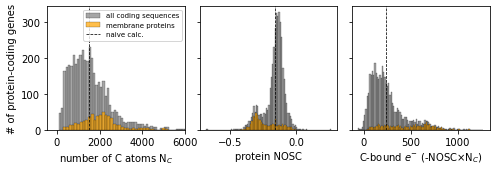

In [21]:
# Histogram of protein NOSC in E. coli
fig, axs = plt.subplots(ncols=3, figsize=(7,2.5), sharey=True)
plt.sca(axs[0])
mask = nosc_df.membrane_protein
plt.hist(nosc_df.NC, color='grey', bins=100, lw=0.3, edgecolor='k', alpha=0.7, label='all coding sequences')
plt.hist(nosc_df[mask].NC, color='orange', bins=50, lw=0.3, edgecolor='k', alpha=0.7, label='membrane proteins')
plt.axvline(300*5, lw=.75, ls='--', color='k', label='naive calc.')

plt.ylabel('# of protein-coding genes')
plt.xlabel('number of C atoms N$_C$')

xmin, xmax = plt.xlim()
plt.xlim(xmin, 6000)

plt.legend(loc=1, fontsize=7)

plt.sca(axs[1])
mask = nosc_df.membrane_protein
plt.hist(nosc_df.NOSC, color='grey', bins=100, lw=0.3, edgecolor='k', alpha=0.7, label='all coding sequences')
plt.hist(nosc_df[mask].NOSC, color='orange', bins=50, lw=0.3, edgecolor='k', alpha=0.7, label='membrane proteins')
plt.axvline(-0.16, lw=.75, ls='--', color='k')

plt.xlabel('protein NOSC', fontsize=10)

plt.sca(axs[2])

plt.hist(-nosc_df.Ce_tot, color='grey', bins=100, lw=0.3, edgecolor='k', alpha=0.7, label='all coding sequences')
plt.hist(-nosc_df[mask].Ce_tot, color='orange', bins=100, lw=0.3, edgecolor='k', alpha=0.7, label='membrane proteins')
plt.axvline(0.16*300*5, lw=.75, ls='--', color='k')

plt.xlabel('C-bound $e^{-}$ (-NOSC$\\times$N$_C$)', fontsize=10)

plt.tight_layout()
plt.savefig('../output/EC_coding_seq_dists.png', facecolor='w', dpi=600)
plt.show()

<AxesSubplot: xlabel='Ce_tot', ylabel='Count'>

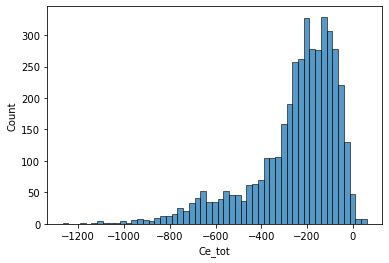

In [5]:
# Hist. of total formal carbon-bound e- on proteins
plt.figure()
sns.histplot(data=nosc_df, x='Ce_tot')

<AxesSubplot: xlabel='MW', ylabel='Count'>

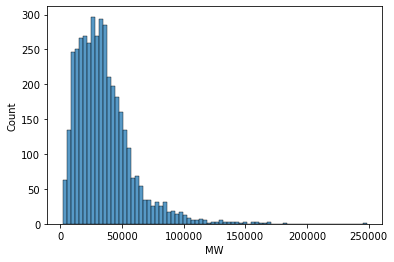

In [6]:
# Hist. of molecular weights
# NB: figure out what these giant proteins are. 
plt.figure()
sns.histplot(data=nosc_df, x='MW')

In [7]:
# filter for "normal-sized" proteins. 
mask = np.logical_and(nosc_df.naa >= 30, nosc_df.naa <= 5000)
all_aas = ''.join(nosc_df[mask].aaseq)
aa_counts_genome = pd.Series(Counter(all_aas))
aa_freqs_genome = aa_counts_genome / aa_counts_genome.sum()

# reorder to match order in amino acid dataset
aa_freqs_genome = aa_freqs_genome.loc[aa_nosc_df.index].copy()

# calculate the genome-frequency-weighted NOSC
nc_aa = aa_nosc_df.NC.copy()
# c-bound e- per aa
ne_aa = aa_nosc_df.NOSC.multiply(nc_aa)
weighted_ne_aa = aa_freqs_genome.multiply(ne_aa)
weighted_nc_aa = aa_freqs_genome.multiply(nc_aa)
expected_NOSC = (weighted_ne_aa.sum() / weighted_nc_aa.sum())
print('expected protein NOSC {0:.3f}'.format(expected_NOSC))

expected protein NOSC -0.161


/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


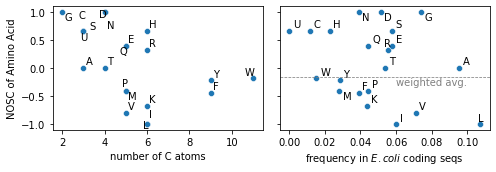

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(7,2.5), sharey=True)
plt.sca(axs[0])
sns.scatterplot(aa_nosc_df.NC, aa_nosc_df.NOSC)

ts = []
for aa in aa_freqs_genome.index:
    xloc = aa_nosc_df.loc[aa].NC + 0.1
    yloc = aa_nosc_df.loc[aa].NOSC + 0.01
    ts.append(plt.annotate(aa, (xloc, yloc)))
adjust_text(ts)
    
plt.xlabel('number of C atoms')
plt.ylabel('NOSC of Amino Acid')

# plot amino acid frequency against NOSC
plt.sca(axs[1])
sns.scatterplot(aa_freqs_genome, aa_nosc_df.NOSC)
plt.axhline(expected_NOSC, ls='--', lw=0.75, color='grey')
plt.text(0.06, expected_NOSC-0.15, 'weighted avg.', ha='left', color='grey')

ts = []
for aa in aa_freqs_genome.index:
    xloc = aa_freqs_genome.loc[aa] + 0.002
    yloc = aa_nosc_df.loc[aa].NOSC + 0.01
    ts.append(plt.annotate(aa, (xloc, yloc)))
adjust_text(ts)

plt.xlabel('frequency in $E. coli$ coding seqs')

plt.tight_layout()
plt.savefig('../output/EC_aa_properties.png', facecolor='w', dpi=600)
plt.show()